# 模型文件地址
    
    https://github.com/PaddlePaddle/models/tree/develop/PaddleCV/image_classification
    
    wget http://paddle-imagenet-models-name.bj.bcebos.com/ResNet50_pretrained.tar
    tar -xvf ResNet50_pretrained.tar
    
# 初始化环境

    pip install opencv-python
    pip install paddlepaddle==1.5
    
    

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import cv2
import time
import sys
import math
import numpy as np
import argparse
import functools

import paddle
import paddle.fluid as fluid

#绘图函数
import matplotlib
#服务器环境设置
import matplotlib.pyplot as plt


#加载自定义文件
from sdk.resnet import ResNet50
from sdk.attack_pp import *


# 创建对抗样本相关的损失函数和标签并加载模型

In [2]:
#http://www.paddlepaddle.org.cn/documentation/docs/zh/1.5/user_guides/howto/prepare_data/index_cn.html

class_dim=1000
image_shape=[3,224,224]
model_name="resnet50"
use_gpu=False
pretrained_model="ResNet50_pretrained"
TOPK=3

adv_program=fluid.Program()

#完成初始化
with fluid.program_guard(adv_program):
    input_layer = fluid.layers.data(name='image', shape=image_shape, dtype='float32')
    #设置为可以计算梯度
    input_layer.stop_gradient=False

    # model definition
    model = ResNet50()
    out = model.net(input=input_layer, class_dim=class_dim)
    out = fluid.layers.softmax(out)

    place = fluid.CUDAPlace(0) if use_gpu else fluid.CPUPlace()
    exe = fluid.Executor(place)
    exe.run(fluid.default_startup_program())

    #记载模型参数
    fluid.io.load_persistables(exe, pretrained_model)
    
#设置adv_program的BN层状态
init_prog(adv_program)      
    
    
#创建测试用评估模式
eval_program = adv_program.clone(for_test=True)

#定义梯度
with fluid.program_guard(adv_program):
    label = fluid.layers.data(name="label", shape=[1] ,dtype='int64')
    loss = fluid.layers.cross_entropy(input=out, label=label)
    #http://www.paddlepaddle.org.cn/documentation/docs/zh/1.5/api_cn/backward_cn.html
    gradients = fluid.backward.gradients(targets=loss, inputs=[input_layer])[0]

  

# 预测原始图片

In [3]:
img_path = "mug227.png"

img=process_img(img_path)

fetch_list = [out.name]

print(img.shape)

result = exe.run(eval_program,
                 fetch_list=fetch_list,
                 feed={ 'image':img })
result = result[0][0]

pred_label = np.argsort(result)[::-1][:TOPK]
print("Test-score: {0}, class {1}".format(result[pred_label], pred_label))
sys.stdout.flush()


o_img=tensor2img(img)


(1, 3, 224, 224)
Test-score: [0.63326067 0.23805845 0.0749701 ], class [504 967 968]


# 调用FGSM算法 无定向攻击

Non-Targeted attack target_label=o_label=504
Test-score: [0.39450884 0.13901028 0.13724369], class [967 504 901]
l0=98.02229485544218% l2=4.269672217353634 linf=15.0


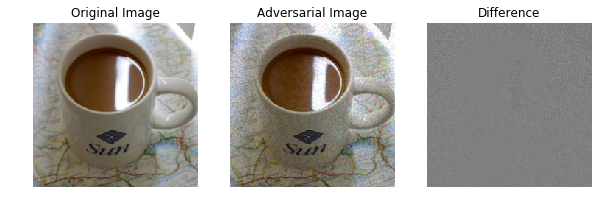

In [4]:
img_path = "mug227.png"
img=process_img(img_path)

#生成对抗样本
#step_size控制了扰动的大小
adv=FGSM(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
         input_layer=input_layer,output_layer=out,step_size=64.0/256.0,epsilon=16.0/256,isTarget=False,target_label=0)

    
result = exe.run(eval_program,
                 fetch_list=fetch_list,
                 feed={ 'image':adv })
result = result[0][0]

pred_label = np.argsort(result)[::-1][:TOPK]

print("Test-score: {0}, class {1}".format(result[pred_label], pred_label))
sys.stdout.flush()

adv_img=tensor2img(adv)

show_images_diff(o_img,adv_img)

# 演示不同$l_{inf}$约束下FGSM无定向攻击的效果

Non-Targeted attack target_label=o_label=504
Test-score: [0.94450766 0.0230325  0.01482625], class [967 504 968] epsilon=0.03125
l0=97.03576743197279% l2=2.1661227595048236 linf=8.0


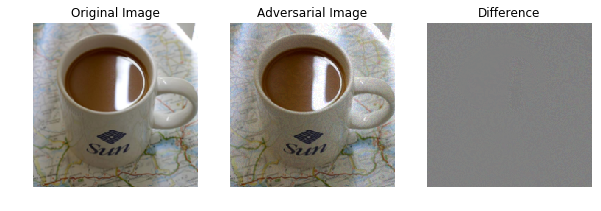

Non-Targeted attack target_label=o_label=504
Test-score: [0.3844351  0.13853714 0.13847637], class [967 901 504] epsilon=0.0625
l0=98.02229485544218% l2=4.300267363523628 linf=16.0


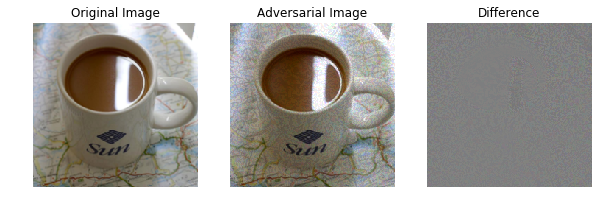

Non-Targeted attack target_label=o_label=504
Test-score: [0.53243387 0.03490353 0.02820862], class [443 610 735] epsilon=0.125
l0=98.32057823129252% l2=8.493948483949133 linf=29.0


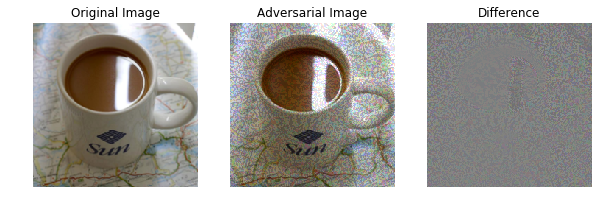

Non-Targeted attack target_label=o_label=504
Test-score: [0.80931133 0.02261997 0.02061118], class [443 111 643] epsilon=0.25
l0=98.6593856292517% l2=12.936290903561959 linf=29.0


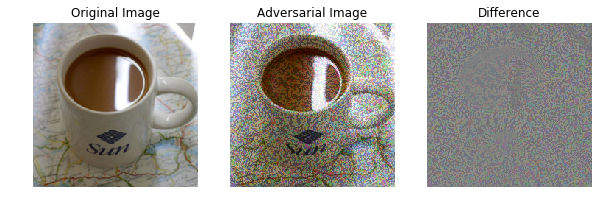

In [5]:
img_path = "mug227.png"
img=process_img(img_path)

for epsilon in [8.0/256,16.0/256,32.0/256,64.0/256]:

    #生成对抗样本
    #step_size控制了扰动的大小
    adv=FGSM(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
             input_layer=input_layer,output_layer=out,step_size=128.0/256.0,epsilon=epsilon,isTarget=False,target_label=0)


    result = exe.run(eval_program,
                     fetch_list=fetch_list,
                     feed={ 'image':adv })
    result = result[0][0]

    pred_label = np.argsort(result)[::-1][:TOPK]

    print("Test-score: {0}, class {1} epsilon={2}".format(result[pred_label], pred_label,epsilon))
    sys.stdout.flush()

    adv_img=tensor2img(adv)

    show_images_diff(o_img,adv_img)

# 调用FGSM算法 定向攻击

Targeted attack target_label=443 o_label=504
Test-score: [0.4836652  0.06317614 0.0470968 ], class [443 643 999]
l0=98.68130846088435% l2=7.0074264852885255 linf=15.0


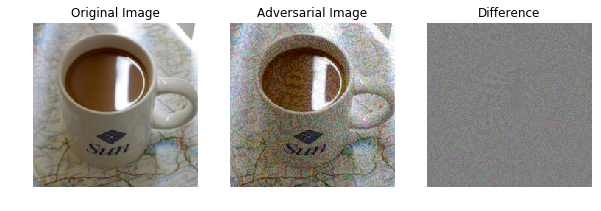

In [6]:
img_path = "mug227.png"
img=process_img(img_path)

#生成对抗样本
adv=FGSM(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
         input_layer=input_layer,output_layer=out,step_size=64.0/256.0,epsilon=64.0/256,isTarget=True,target_label=443)

    
result = exe.run(eval_program,
                 fetch_list=fetch_list,
                 feed={ 'image':adv })
result = result[0][0]

pred_label = np.argsort(result)[::-1][:TOPK]

print("Test-score: {0}, class {1}".format(result[pred_label], pred_label))
sys.stdout.flush()

adv_img=tensor2img(adv)

#展示原始图片和对抗样本的差异
show_images_diff(o_img,adv_img)

# 演示不同$l_{inf}$约束下FGSM定向攻击的效果

Targeted attack target_label=443 o_label=504
Test-score: [0.35896572 0.07235267 0.03942896], class [443 999 725] epsilon=0.03125
l0=97.04706101190476% l2=2.1699268559611298 linf=8.0


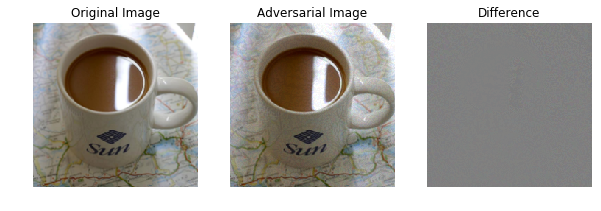

Targeted attack target_label=443 o_label=504
Test-score: [0.5642405  0.06470703 0.03412949], class [443 999 643] epsilon=0.0625
l0=98.04421768707483% l2=4.277600987952368 linf=15.0


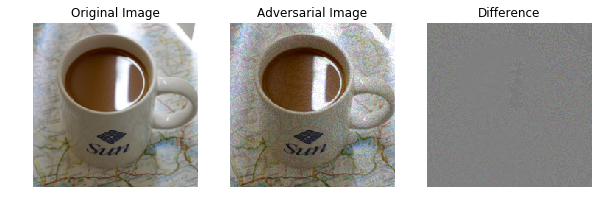

Targeted attack target_label=443 o_label=504
Test-score: [0.578282   0.05376711 0.04214723], class [443 643 999] epsilon=0.125
l0=98.35047300170068% l2=6.451348841058908 linf=15.0


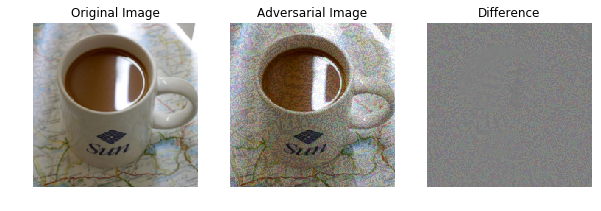

Targeted attack target_label=443 o_label=504
Test-score: [0.4836652  0.06317614 0.0470968 ], class [443 643 999] epsilon=0.25
l0=98.68130846088435% l2=7.0074264852885255 linf=15.0


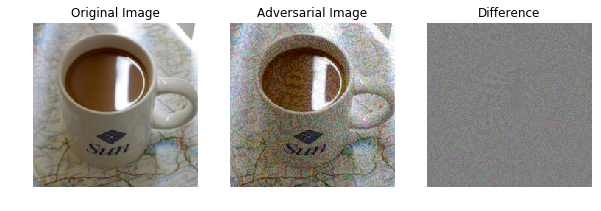

In [7]:
img_path = "mug227.png"
img=process_img(img_path)

for epsilon in [8.0/256,16.0/256,32.0/256,64.0/256]:

    #生成对抗样本
    #step_size控制了扰动的大小
    adv=FGSM(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
             input_layer=input_layer,output_layer=out,step_size=64.0/256.0,epsilon=epsilon,isTarget=True,target_label=443)


    result = exe.run(eval_program,
                     fetch_list=fetch_list,
                     feed={ 'image':adv })
    result = result[0][0]

    pred_label = np.argsort(result)[::-1][:TOPK]

    print("Test-score: {0}, class {1} epsilon={2}".format(result[pred_label], pred_label,epsilon))
    sys.stdout.flush()

    adv_img=tensor2img(adv)

    show_images_diff(o_img,adv_img)

# 调用PGD算法 无定向攻击

Non-Targeted attack target_label=o_label=504
Test-score: [1.0000000e+00 2.2026656e-09 5.1059812e-12], class [967 550 968]
l0=84.11989795918367% l2=1.3004155986324781 linf=9.0


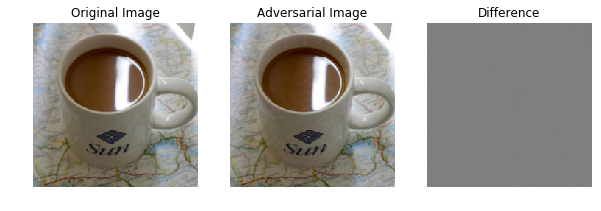

In [8]:
img_path = "mug227.png"
img=process_img(img_path)

#生成对抗样本
#step_size控制了扰动的大小
adv=PGD(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
         input_layer=input_layer,output_layer=out,step_size=2.0/256.0,epsilon=16.0/256,iteration=20,isTarget=False,target_label=0)

    
result = exe.run(eval_program,
                 fetch_list=fetch_list,
                 feed={ 'image':adv })
result = result[0][0]

pred_label = np.argsort(result)[::-1][:TOPK]

print("Test-score: {0}, class {1}".format(result[pred_label], pred_label))
sys.stdout.flush()

adv_img=tensor2img(adv)

show_images_diff(o_img,adv_img)

# 调用PGD算法 定向攻击

Targeted attack target_label=968 o_label=504
Test-score: [9.9999952e-01 3.8640241e-07 4.3708425e-08], class [968 504 967]
l0=67.81396152210884% l2=0.811885242523172 linf=5.0


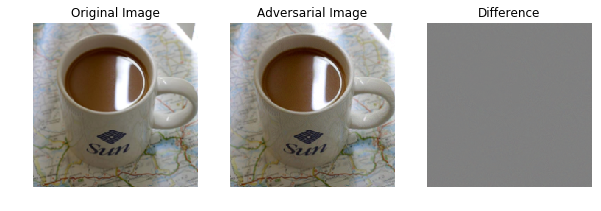

In [9]:
img_path = "mug227.png"
img=process_img(img_path)

#生成对抗样本
#step_size控制了扰动的大小
adv=PGD(adv_program=adv_program,eval_program=eval_program,gradients=gradients,o=img,
         input_layer=input_layer,output_layer=out,step_size=1.0/256.0,epsilon=16.0/256,iteration=20,isTarget=True,target_label=968)

    
result = exe.run(eval_program,
                 fetch_list=fetch_list,
                 feed={ 'image':adv })
result = result[0][0]

pred_label = np.argsort(result)[::-1][:TOPK]

print("Test-score: {0}, class {1}".format(result[pred_label], pred_label))
sys.stdout.flush()

adv_img=tensor2img(adv)

show_images_diff(o_img,adv_img)